In [21]:
import numpy as np
from astropy import constants as ca
from funcs.blackbody_model import _brightness_mod, brightness_mod_continous
from funcs.probabilities_emcee import log_likelihood, log_prior_global_uniform, \
    log_probability, plot_corner_emcee, plot_walker_emcee, display_median_from_chain, \
    log_loglikelihood, log_logprior_global_uniform, log_logprobability
import sys 
import matplotlib.pyplot as plt
import astropy.units as u

In [ ]:
#this is a good thing to play a little around with! 

In [2]:
#import brightness and error for each Flare and TRAPPIST-1
flare1 = np.genfromtxt("Test/results/values/brightness_flare_Test.txt",delimiter="," , skip_header=1)
#flare2 = np.genfromtxt("../results/values/brightnesstot_flare2_TRAPPIST-1.txt",delimiter="," , skip_header=1)
trappist = np.genfromtxt("Test/results/values/brightness_Test_withCCDeffeciency.txt", delimiter= ",", skip_header=1)
trappist_SED = np.genfromtxt("../data/TRAPPIST1_Semimodel_Wilson/TRAPPIST-1_model_const_res_v07.ecsv")
trappistflux_M2 = np.genfromtxt("../results/values/brightness_TRAPPIST-1_withCCDeffeciency.txt", delimiter= ",", skip_header=1)

In [3]:
#import flare brightness and spectral energy dist. in M2
wavelength_SED, flux_SED = trappist_SED[:,0]*1e-10, trappist_SED[:,1]
brightness_flares = np.reshape(flare1, (1,4))

brightnesserror_flares = np.reshape(flare1, (1,4)) * 0.25
#flux/brighntess is in erg cm-2 -s

#Import M2 response, passband limits
iters = ["g", "r", "i", "z"]
limit, wavelength_M2, response_M2 = [], [], []

for i in iters: 
    #limit are the limits of the passband in wavelength 
    limit.append(np.load("../data/MuSCAT2_response/MuSCAT2_limit_{}.npy".format(str(i))))
    wavelength_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_wavelength_{}.npy".format(str(i))))
    response_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_response_{}_bandpass.npy".format(str(i))))

In [ ]:
#units of brightness flares? I think it should be in standart units SI

In [4]:
flux_SED = flux_SED * u.erg * u.s**(-1) *u.cm**(-2) * u.Angstrom**(-1)
flux_SED = flux_SED.to("W m^-3")
flux_SED = flux_SED.value

In [5]:
from scipy.optimize import minimize

#Define parameters of the TRAPPIST-1
parameters_op = []
t_star = 2648 #[K] #Wilson et al 2021
r_star = 0.1192 * ca.R_sun.value
dist_star = dist_TRAP = 3.835084e+17 #[m]

#initial values for MCMC
for i in range(len(brightness_flares)):
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([5000,0.1] + 0.01 * np.random.randn(2))
    soln = minimize(nll, initial, args=(wavelength_SED, brightness_flares[i], \
                                        brightnesserror_flares[i], limit, flux_SED, \
                                        t_star, r_star, dist_star))
    T_op, a_op = soln.x 
    
    #ensure Temperature is not to high
    if T_op > 25000 or T_op < 3000:
        T_op = 6000 
        
    #ensure fraction of area is not negative
    if a_op < 0:
        a_op = 1e-6
    
    parameters_op.append([T_op, a_op])

parameters_op = np.asarray(parameters_op)

In [11]:
parameters_op

array([[5.01097397e+03, 1.00000000e-06]])

In [22]:
import emcee
import corner
import matplotlib.pyplot as plt


n = 3000 #number of steps in the chain
ndim = 2 #dimensions of the model i.e. parameters in the model
nwalkers = 40 #number of walkers

samples_total, samplesflat_total = [],[] 

#Emcee Flare fitting
for i in range(len(brightness_flares)):
    sys.stdout.write("Flare #" + str(i+1))
    
    pos = parameters_op[i] + 1e-8 * np.random.randn(nwalkers, ndim)
    
    
    
    #sampler
    sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability, args=(wavelength_SED, brightness_flares[i],\
                                                       brightnesserror_flares[i], limit, flux_SED, \
                                                       t_star, r_star, dist_star, log_prior_global_uniform))
    sampler.run_mcmc(pos, n, progress=True, )
    
    #flattensamples and discard burn in phase
    samplesflat_total.append(sampler.get_chain(discard=500, thin=15, flat=True))
    samples_total.append(sampler.get_chain())
    

  0%|          | 8/3000 [00:00<00:41, 72.87it/s]

Flare #1

100%|██████████| 3000/3000 [00:40<00:00, 74.76it/s]


In [7]:
import emcee
import corner
import matplotlib.pyplot as plt


n = 1000 #number of steps in the chain
ndim = 2 #dimensions of the model i.e. parameters in the model
nwalkers = 40 #number of walkers

samples_total, samplesflat_total = [],[] 

#Emcee Flare fitting
for i in range(len(brightness_flares)):
    sys.stdout.write("Flare #" + str(i+1))
    
    pos = np.log10(parameters_op[i] + 1e-8 * np.random.randn(nwalkers, ndim))
    
    
    
    #sampler
    sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_logprobability, args=(wavelength_SED, brightness_flares[i],\
                                                       brightnesserror_flares[i], limit, flux_SED, \
                                                       t_star, r_star, dist_star, log_logprior_global_uniform))
    sampler.run_mcmc(pos, n, progress=True, )
    
    #flattensamples and discard burn in phase
    samplesflat_total.append(sampler.get_chain(discard=500, thin=15, flat=True))
    samples_total.append(sampler.get_chain())
    

  1%|          | 8/1000 [00:00<00:13, 75.70it/s]

Flare #1

100%|██████████| 1000/1000 [00:12<00:00, 77.26it/s]


In [29]:
#Write chain data to arrays 

np.save("../data/MCMC/samples_total", samples_total, allow_pickle=True, fix_imports=True)
np.save("../data/MCMC/samplesflat_total", samplesflat_total, allow_pickle=True, fix_imports=True)

In [30]:
#Load data from chain 

samples_total = np.load("../data/MCMC/samples_total.npy")
samplesflat_total = np.load("../data/MCMC/samplesflat_total.npy")

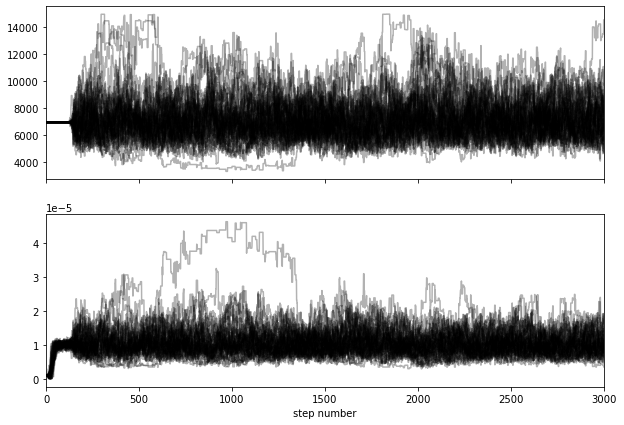

In [23]:
%matplotlib inline
plot_walker_emcee(samples_total)

In [24]:
def plot_corner_emcee(samples_flat, bins = 100, labels = ["T","a"]):
    
    for j in range(len(samples_flat)):
        fig = corner.corner(
        samples_flat[j], labels=labels, bins = bins
        );
    return 

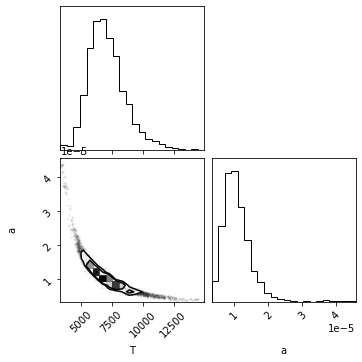

In [27]:
plot_corner_emcee(samplesflat_total, bins=22)

In [15]:
results = display_median_from_chain(samplesflat_total)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(7079.457843841381, 1.2589254117941661e-05)

In [32]:
import pandas as pd 
muscat = pd.read_csv("../data/MuSCAT2_response/MuSCAT2_response.csv")

muscat = muscat.fillna(0) 
muscat["lamb"] = muscat.wavelength * 10 #Angstrom

response =  np.asarray([np.nansum(muscat.Total_g), \
           np.nansum(muscat.Total_r), \
           np.nansum(muscat.Total_i), \
           np.nansum(muscat.Total_z) ])

In [15]:
T_med = results[0][0]
a_med = results[2][0]

T_high = results[0][0] + results[1][0][1]
T_low = results[0][0] - results[1][0][0]
a_high = results[2][0] + results[3][1][0]
a_low = results[2][0] - results[3][1][0]


In [47]:
brightness_flaresraw = np.genfromtxt("../results/values/brightness_flare1_TRAPPIST-1.txt",delimiter="," , skip_header=1)

In [41]:
#resps fehlen
br1 = brightness_flaresraw[0] * np.asarray([np.mean(trappist_SED[:,1][limit[0][0]:limit[0][1]]), np.mean(trappist_SED[:,1][limit[1][0]:limit[1][1]]) , np.mean(trappist_SED[:,1][limit[2][0]:limit[2][1]]) , np.mean(trappist_SED[:,1][limit[3][0]:limit[3][1]])]  )
np.sqrt(brightness_flaresraw[1]**2 * np.asarray([np.mean(trappist_SED[:,1][limit[0][0]:limit[0][1]]), np.mean(trappist_SED[:,1][limit[1][0]:limit[1][1]]) , np.mean(trappist_SED[:,1][limit[2][0]:limit[2][1]]) , np.mean(trappist_SED[:,1][limit[3][0]:limit[3][1]])])**2 +   np.asarray([np.std(trappist_SED[:,1][limit[0][0]:limit[0][1]]), np.std(trappist_SED[:,1][limit[1][0]:limit[1][1]]) , np.std(trappist_SED[:,1][limit[2][0]:limit[2][1]]) , np.std(trappist_SED[:,1][limit[3][0]:limit[3][1]])])**2 *brightness_flaresraw[0]**2 )

array([4.49004509e-14, 3.22910006e-14, 2.04929047e-14, 6.82231180e-15])

In [46]:
brightness_fl = np.genfromtxt("../results/values/brightness_mean_TRAPPIST-1_withCCDeffeciency.txt", delimiter=",", skip_header=1)

In [55]:
brightness_reduces = brightness_flaresraw[0] * brightness_flares[0] 

In [58]:
brightness_flaresraw, brightness_flares

(array([[4.52506984e+02, 1.51050116e+02, 1.01800624e+01, 2.82384713e+00],
        [1.14871321e+00, 2.05387732e+00, 3.04184981e-01, 4.18429654e-01]]),
 array([[5.74516147e-14, 4.22547075e-14, 2.17100543e-14, 8.67612419e-15],
        [1.81192030e-15, 1.69265145e-15, 9.04967349e-16, 1.77293049e-16]]))

<IPython.core.display.Javascript object>


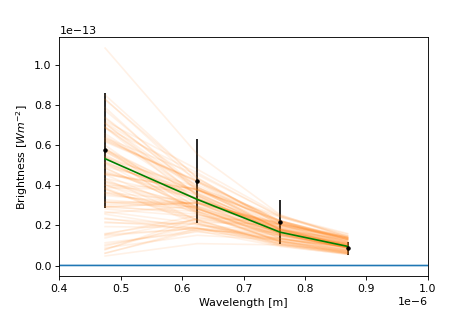

/home/aaronmaas/Desktop/Flares_Trappist/notebooks/funcs/blackbody_model.py:6: RuntimeWarning: overflow encountered in exp
  flare_contribution = (a*R_star)**2/(np.exp((c.h * c.c)/(T_flare*c.k*wavelength)) -1)


Text(0, 0.5, 'Brightness [$W m^{-2}$]')

In [40]:
import matplotlib.pyplot as plt 
%matplotlib notebook
#def plot_residual_plot(): 
inds = np.random.randint(len(samplesflat_total[0]), size=100) #
for ind in inds:
    sample = samplesflat_total[0][ind]
    plt.plot(wavelength_M2, _brightness_mod(wavelength_SED,limit,sample[0],sample[1], flux_SED,t_star, R_star = r_star, dist_star = dist_TRAP), "C1", alpha=0.1)
plt.plot(wavelength_M2, _brightness_mod(wavelength_SED,limit,T_med,a_med, flux_SED,t_star, R_star = r_star, dist_star = dist_star), "green", alpha=1)
#plt.plot(wavelength_M2, _brightness_mod(wavelength_SED,limit,5000,0.001, flux_SED,t_star, R_star = r_star, dist_star = dist_star), "red", alpha=1)
plt.errorbar(wavelength_M2, brightness_flares[0], yerr=brightnesserror_flares[0], fmt=".k", capsize=0)
#plt.errorbar(wavelength_M2, brightness_reduces, yerr=brightnesserror_flares[0]/response/5, fmt=".k", capsize=0)
plt.plot(wavelength_SED, brightness_mod_continous(wavelength_SED,T_med, a_med, trappist_SED[:,1], t_star, R_star = r_star, dist_star = dist_star, model = None))
plt.xlabel("Wavelength [m]")
plt.xlim(0.4e-6,1e-6)
#plt.errorbar(wavelength_M2,[4.49004509e-14, 3.22910006e-14, 2.04929047e-14, 6.82231180e-15], yerr = [4.49004509e-14, 3.22910006e-14, 2.04929047e-14, 6.82231180e-15] ,fmt=".k", capsize=0 )
plt.ylabel(r"Brightness [$W m^{-2}$]")
#plt.legend() 

In [50]:
_brightness_mod(wavelength_SED,limit,T_med,a_med, flux_SED,t_star, R_star = r_star, dist_star = dist_star)

array([6.20357187e-14, 3.53401150e-14, 1.70403410e-14, 9.66291998e-15])

In [179]:
lc = [4.745e-07, 6.245e-07, 7.6e-07, 8.695000000000001e-07]
ranges = np.asarray([1.4999999999999994e-07, 1.5000000000000005e-07, 1.1900000000000005e-07, 1e-07])/2*1e9

In [170]:
wavelength_M2

[array(4.745e-07), array(6.245e-07), array(7.6e-07), array(8.695e-07)]

/home/aaronmaas/Desktop/Flares_Trappist/notebooks/funcs/blackbody_model.py:6: RuntimeWarning: overflow encountered in exp
  flare_contribution = (a*R_star)**2/(np.exp((c.h * c.c)/(T_flare*c.k*wavelength)) -1)


<IPython.core.display.Javascript object>


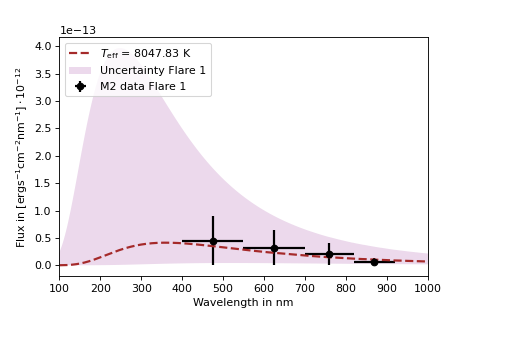

In [180]:
import matplotlib.pyplot as plt
#4890.07968612]), array([5086.15002762
up = brightness_mod_continous(wavelength_SED,T_high, a_high, trappist_SED[:,1], t_star, R_star = r_star, dist_star = dist_star, model = None)
low = brightness_mod_continous(wavelength_SED,T_low, a_low, trappist_SED[:,1], t_star, R_star = r_star, dist_star = dist_star, model = None)
#up = 1e-9*1e-4*1e7*1e12* np.asarray(blackbody_TRAP_othick_(wavelength_TRAP*1e-10, 5973, 0.49))
#low =   1e-9*1e-4*1e7*1e12* np.asarray(blackbody_TRAP_othick_(wavelength_TRAP*1e-10, 6909, 0.62))
#low1 = 1e-9*1e-4*1e7*1e12*np.asarray(blackbody_TRAP_othick_(wavelength_TRAP*1e-10, 5712, 0.44))
#up1 =   1e-9*1e-4*1e7*1e12*np.asarray(blackbody_TRAP_othick_(wavelength_TRAP*1e-10, 7327, 0.55))

plt.errorbar(np.asarray(wavelength_M2)*1e9,np.asarray([4.49004509e-14, 3.22910006e-14, 2.04929047e-14, 6.82231180e-15]), xerr = ranges, yerr = [4.49004509e-14, 3.22910006e-14, 2.04929047e-14, 6.82231180e-15] ,fmt=".k", capsize=0, \
                         ls = 'None', marker = 'o', linewidth = 2 ,  label = "M2 data Flare 1")

plt.plot(wavelength_SED*1e9,  \
         brightness_mod_continous(wavelength_SED, T_med, a_med, trappist_SED[:,1], t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
         label = "$T_\mathrm{eff}$ = 8047.83 K", linewidth = 2, color = "brown") #, array([5127.88550742]



#plt.plot(wavelength_TRAP*1e-1, 1e-9*1e-4*1e7*1e12*(a_fitted2*R_TRAP)**2/dist_TRAP**2 * np.pi * \
       #  blackbodyw_wout(wavelength_TRAP*1e-10, T_fitted2), ls = "dashdot",\
       #  label = "$T_\mathrm{eff}$ = 5320 K", linewidth = 2, color = "brown") #   

plt.fill_between(wavelength_SED*1e9, up, low, facecolor = "purple", alpha = 0.15, label = "Uncertainty Flare 1")
#plt.fill_between(wavelength_TRAP*1e-1, up1, low1, facecolor = "brown", alpha = 0.15, label = "Uncertainty Flare 2")

plt.xlim(100,1000)
#plt.ylim(0)
plt.xlabel("Wavelength in nm")
plt.ylabel(r"Flux in $[\mathrm{erg} \mathrm{s}^{-1} \mathrm{cm}^{-2} \mathrm{nm}^{-1}] \cdot 10^{-12}$")
#plt.ylim(1e3,1e7)

plt.legend(loc = "upper left", frameon = "False") 




In [ ]:
#Nice SED plot how? 
#corrected data points; with corrected model; --> sunday

In [ ]:
# Notes: 

'''
Open question, if I do that do I not do it twice?? This is a really good question. Because in the photometry, 
the information about the CCD effeciency should be in there already. Correct? Nope see enrics mail.

Next step: 
Functions of the analysis plots; stil bug with factor? I do not see where it is coming
from. Also safe the chain!

Also, the spectrum and the observaion should have something together, in theory the flare 
Spectrum should be reporduceable!


'''

In [13]:
import scipy.constants as c
def _brightness_mod(wavelength_tot, limit, T_flare, a, fluxdensity_tot, T_star, R_star, dist_star, model = "thick"):
    
    '''
    Modified brightness calculator for every passband. It summs the brightness in the given limits. 
    So for Muscat we get four summed points. The model uses an optical thick approach. 

    Parameters
    -------------
    wavelength_tot : 1-d array
        total wavelength array to be sliced into passband contributions by limit
    limit: mx2-array
        m is the number of passbands, 2 because two boarders 
    T_flare: float
        Flare temperature [K]
    a: float
        Fraction of Radius of the star asociate with flaring area. 
    fluxdensity_tot: 1-d array
        total fluxdensity of the star given [W/m^3] 
    Stellar Paramer 
    --------------
    T_star: float 
        Temperature of star [K]
    R_star: float
        Radius of star [m]
    dist_star
        distance of star [m]
        
    Return 
    ----------
    mx1 array
        Apparent brightness of flare in the passbands at Earth
    
    '''
    
    
    brightness = []
    for i in range(len(limit)):
        wavelength = wavelength_tot[limit[i][0]:limit[i][1]]
        pre_factor = 1/(dist_star**2) * 2*c.h*c.c**2 /(wavelength**5) * np.pi
        flare_contribution = np.nansum(pre_factor* (a*R_star)**2/(np.exp((c.h * c.c)/(T_flare*c.k*wavelength)) -1))
        if model == "thick":
            #total star in given passband #das ist super klein, deswegen hat es kaum einen Einfluss
            star_contribution = -(a)**2 * np.trapz(fluxdensity_tot[limit[i][0]:limit[i][1]])   #R_star/dist_star weg #es macht Sinn nur den faktro a da zu haben, wegen l = sum flux l_a = a sum flux
        else: 
            #thin case, a sign
            star_contribution = (a)**2 * np.trapz(fluxdensity_tot[limit[i][0]:limit[i][1]])  
        print(star_contribution)
        print(flare_contribution)
        brightness.append(flare_contribution  + star_contribution) 
        
    return np.asarray(brightness)

-3.692030141202421e-18
4.277060093651539e-14
-9.91707471824821e-18
3.054876204862149e-14
-8.016812435572932e-17
1.663899970664624e-14
-1.66335836719441e-16
1.0085345828740228e-14


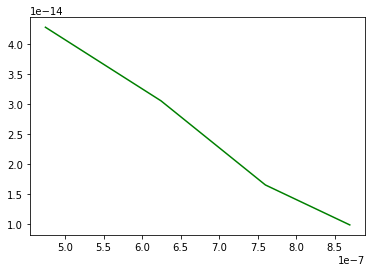

In [16]:
plt.plot(wavelength_M2, _brightness_mod(wavelength_SED,limit,T_med,a_med, flux_SED,t_star, R_star = r_star, dist_star = dist_star), "green", alpha=1)